In [1]:
import math
import numpy as np
import scipy.integrate as integrate   # для решения ОДУ в методе DEM
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rc('xtick', labelsize = 12) 
matplotlib.rc('ytick', labelsize = 12) 

# Hashin–Shtrikman bounds (HS)

In [2]:
# HS - bulk модуль - 2 компоненты (prop - в процентах)
def get_HS_bulk_bounds(bulk, shear, prop):
    # функция возвращает верхнюю и нижнюю границы HS для объемного модуля сжатия (bulk) композита,
    # состоящего из двух компонент

    # входные данные
    k1, k2 = bulk        # объемные модули сжатия (bulk) 1ой и 2ой компонент
    g1, g2 = shear       # модули сдвига (shear) 1ой и 2ой компонент
    f1 = prop / 100       # объмное содержание 1ой компоненты (f1 - в долях, prop - в %)
    f2 = 1 - prop / 100   # объемное содержание 2ой компоненты
    
    # случай 1
    if k1 == k2:
        return k

    # случай 2: (k1 > k2) and (g1 > g2) - компонента 1 более жесткая
    if ((k1 - k2) * (g1 - g2) > 0) or (g1 == g2):
        bulk_bounds = sorted([k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3)),
                               k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3))])
    else:
        # случай 3.1: (k1 > k2) but (g1 < g2)
        if k1 > k2:
            if k1 + 0.5 / (1 / (k2 - k1) + 0.5 / (k1 + 4 * g1 / 3)) > k2 + 0.5 / (
                    1 / (k1 - k2) + 0.5 / (k2 + 4 * g2 / 3)):
                bulk_bounds = [k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3)),
                               k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3))]
            else:
                bulk_bounds = [k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3)),
                               k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3))]
        # случай 3.2: (k1 < k2) but (g1 > g2)
        else:
            if k1 + 0.5 / (1 / (k2 - k1) + 0.5 / (k1 + 4 * g1 / 3)) > k2 + 0.5 / (
                    1 / (k1 - k2) + 0.5 / (k2 + 4 * g2 / 3)):
                bulk_bounds = [k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3)),
                               k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3))]
            else:
                bulk_bounds = [k1 + f2 / (1 / (k2 - k1) + f1 / (k1 + 4 * g1 / 3)),
                               k2 + f1 / (1 / (k1 - k2) + f2 / (k2 + 4 * g2 / 3))]

    return bulk_bounds



# HS - shear модуль - 2 компоненты (prop - в процентах)
def get_HS_shear_bounds(bulk, shear, prop):
    # функция возвращает верхнюю и нижнюю границы HS для модуля сдвига (shear) композита,
    # состоящего из двух компонент

    # входные данные
    k1, k2 = bulk  # объемные модули сжатия (bulk) 1ой и 2ой компонент
    g1, g2 = shear  # модули сдвига (shear) 1ой и 2ой компонент
    f1 = prop / 100  # объмное содержание 1ой компоненты (f1 - в долях, prop - в %)
    f2 = 1 - prop / 100  # объемное содержание 2ой компоненты

    # случай 1
    if g1 == g2:
        return shear

    # случай 2: (k1 > k2) and (g1 > g2) - компонента 1 более жесткая
    if ((k1 - k2) * (g1 - g2) > 0) or (k1 == k2):
        shear_bounds = sorted([g1 + f2 / (1 / (g2 - g1) + 2 * f1 * (k1 + 2 * g1) / (5 * g1 * (k1 + 4 * g1 / 3))),
                               g2 + f1 / (1 / (g1 - g2) + 2 * f2 * (k2 + 2 * g2) / (5 * g2 * (k2 + 4 * g2 / 3)))])
    else:
        if g1 > g2:
            if g2 + 0.5 / (1 / (g1 - g2) + 0.5 / (g2 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (
                    min(bulk) + 2 * min(shear))) / 6)) > g1 + 0.5 / (
                    1 / (g2 - g1) + 0.5 / (g1 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6)):
                shear_bounds = [g1 + f2 / (1 / (g2 - g1) + f1 / (
                                    g1 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6)),
                                g2 + f1 / (
                                        1 / (g1 - g2) + f2 / (
                                            g2 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6))]
            else:
                shear_bounds = [g2 + f1 / (
                    1 / (g1 - g2) + f2 / (g2 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6)),
                            g1 + f2 / (1 / (g2 - g1) + f1 / (
                                    g1 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6))]
        else:
            if g2 + f1 / (1 / (g1 - g2) + f2 / (g2 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (
                    max(bulk) + 2 * max(shear))) / 6)) > g1 + f2 / (
                    1 / (g2 - g1) + f1 / (g1 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6)):
                shear_bounds = [g1 + f2 / (
                        1 / (g2 - g1) + f1 / (g1 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6)),
                                g2 + f1 / (1 / (g1 - g2) + f2 / (
                                        g2 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6))]
            else:
                shear_bounds = [g2 + f1 / (1 / (g1 - g2) + f2 / (
                                        g2 + max(shear) * ((9 * max(bulk) + 8 * max(shear)) / (max(bulk) + 2 * max(shear))) / 6)),
                                g1 + f2 / (1 / (g2 - g1) + f1 / (
                                        g1 + min(shear) * ((9 * min(bulk) + 8 * min(shear)) / (min(bulk) + 2 * min(shear))) / 6))]

    return shear_bounds


# вспомогательная (prop - в процентах)
def get_proportion_for_HS(prop1, prop2):
    # функция является вспомогательной для нахождения границ HS для многих компонент,
    # на вход принимает процентное содержание двух компонент в составе многих и
    # пересчитывает их в предположении, что в сумме две компоненты дают 100%

    sum = prop1 + prop2
    final_prop = (prop1/sum)*100
    return final_prop



# HS - bulk и shear модули - много компонент (prop - в процентах)
def get_HS_for_many_components(bulk, shear, prop):
    # функция возвращает верхнюю и нижнюю границы HS для bulk и shear модулей композита,
    # состоящего из N компонент

    # на вход подаются два массива, содержащие значения bulk и shear модулей N компонент
    # bulk = [k1, k2, ..., ki, ..., kn], shear = [g1, g2, ..., gi, ..., gn]
    # также подается массив prop, содержащий процентное содержание всех компонент в %

    N = len(bulk)
    if N >= 3:
        for _ in range(N - 2):

            # будем брать в каждом массиве по 2 последних элемента и считать их границы HS
            bulk_for_2 = [bulk[-1], bulk[-2]]
            shear_for_2 = [shear[-1], shear[-2]]
            prop_for_2 = get_proportion_for_HS(prop[-1], prop[-2])

            bulk_bounds = get_HS_bulk_bounds(bulk_for_2, shear_for_2, prop_for_2)
            shear_bounds = get_HS_shear_bounds(bulk_for_2, shear_for_2, prop_for_2)

            bulk[-2] = np.mean(bulk_bounds)
            shear[-2] = np.mean(shear_bounds)
            prop[-2] = prop[-1] + prop[-2]

            bulk.pop(-1)
            shear.pop(-1)
            prop.pop(-1)

            print(bulk)
            print(shear)
            print(prop)

        # когда остались только 2 компоненты, применяем к ним метод HS для двух компонент
        final_bulk_bounds = get_HS_bulk_bounds(bulk, shear, prop[0])
        final_shear_bounds = get_HS_shear_bounds(bulk, shear, prop[0])

    else:   # на случай, если с помощью этой функции хотят посчитать HS для 2х комонент
        final_bulk_bounds = get_HS_bulk_bounds(bulk, shear, prop)
        final_shear_bounds = get_HS_shear_bounds(bulk, shear, prop)

    return final_bulk_bounds, final_shear_bounds


# HS - bulk и shear модули - 2 компоненты - для всех пропорций
def get_HS_for_all_proportions(comp1, comp2, sampling_step = 100):
    # функция рассчитывает границы HS для всех отношений двух компонент
    # на вход принимаются значения упругих модулей и параметр дискретизации

    bulk = [comp1[0], comp2[0]]
    shear = [comp1[1], comp2[1]]

    proportion = []
    bulk_up = []
    bulk_down = []
    shear_up = []
    shear_down = []

    average_bulk = []
    average_shear = []

    for prop in range(sampling_step):
        proportion.append(prop/sampling_step)

        current_bulk = get_HS_bulk_bounds(bulk, shear, prop)
        current_shear = get_HS_shear_bounds(bulk, shear, prop)

        bulk_up.append(current_bulk[1])
        bulk_down.append(current_bulk[0])
        shear_up.append(current_bulk[1])
        shear_down.append(current_bulk[0])

        average_bulk.append((current_bulk[0] + current_bulk[1])/2)
        average_shear.append((current_shear[0] + current_shear[1]) / 2)

    return proportion, average_bulk, average_shear


# HS - bulk и shear модули смеси двух твердых компонент
def get_moduli_by_HS(get_HS_for_all_proportions, comp1, comp2, proportion):
    # proportion - содержание первой компоненты в %

    prop, average_bulk, average_shear = get_HS_for_all_proportions(comp1, comp2)

    index = prop.index(proportion/100)

    return [average_bulk[index], average_shear[index]]

# Self-Consistent Approximation (SCA) 

In [3]:
def get_all_values_by_SCA(pores, matrix, sampling_step = 100):
    # функция принимает на вход два массива следующего вида:
    # pores = [bulk_p, shear_p, asp_p], где элементы массива: bulk и shear модули и аспектное отношение флюида,
        # насыщающего поры (воздух, например)
    # matrix = [bulk_m, shear_m, asp_m]
    # porosity - пористость

    # возвращает bulk и shear модули композита матрица+поры

    k1, n1, asp1 = pores
    k2, n2, asp2 = matrix

    kbr = []
    nbr = []
    por = []

    # чтобы нигде не было деления на 0
    if asp1 == 1:
        asp1 = 0.99
    if asp2 == 1:
        asp2 = 0.99



    # вычислим theta и fn (через аспектное отношения), которые понадобятся для дальнейших рассчетов

    # asp < 1 - oblate spheroid (сплюснутый элипсоид)
    if asp1 < 1:
        theta1 = (asp1 / ((1 - asp1 ** 2) ** (3 / 2))) * (math.acos(asp1) - asp1 * math.sqrt(1 - asp1 ** 2))
        fn1 = (asp1 ** 2 / (1 - asp1 ** 2)) * (3 * theta1 - 2)

    if asp2 < 1:
        theta2 = (asp2 / ((1 - asp2 ** 2) ** (3 / 2))) * (math.acos(asp2) - asp2 * math.sqrt(1 - asp2 ** 2))
        fn2 = (asp2 ** 2 / (1 - asp2 ** 2)) * (3 * theta2 - 2)

    # asp > 1 - prolate spheroid (вытянутый элипсоид)
    if asp1 > 1:
        theta1 = (asp1 / ((asp1 ** 2 - 1) ** (3 / 2))) * (asp1 * math.sqrt(asp1 ** 2 - 1) - math.acosh(asp1))
        fn1 = (asp1 ** 2 / (asp1 ** 2 - 1)) * (2 - 3 * theta1)

    if asp2 > 1:
        theta2 = (asp2 / ((asp2 ** 2 - 1) ** (3 / 2))) * (asp2 * math.sqrt(asp2 ** 2 - 1) - math.acosh(asp2))
        fn2 = (asp2 ** 2 / (asp2 ** 2 - 1)) * (2 - 3 * theta2)

    epsilon = 1e-7   # опять же, чтобы нигде не было деления на ноль

    if k1 == 0:
        k1 = 1e-3
    if k2 == 0:
        k2 = 1e-3
    if n1 == 0:
        n1 = 1e-3
    if n2 == 0:
        n2 = 1e-3

    # пройдем по всем значениям пористости от 0 до 100%
    # x1 - пористость, x2 - содержание твердой компоненты
    for x1 in [epsilon] + [i /sampling_step for i in range(1, sampling_step)] + [1 - epsilon]:
        x2 = 1 - x1

        ksc = x1 * k1 + x2 * k2
        nsc = x1 * n1 + x2 * n2
        knew = 0
        nnew = 0
        tol = 1e-6 * k1
        d = abs(ksc - knew)
        niter = 0

        if nsc == 0:
            pass

        while (d > abs(tol)) and (niter < 3000):
            nusc = (3 * ksc - 2 * nsc) / (2 * (3 * ksc + nsc))
            a1 = n1 / nsc - 1
            a2 = n2 / nsc - 1
            b1 = (1 / 3) * (k1 / ksc - n1 / nsc)
            b2 = (1 / 3) * (k2 / ksc - n2 / nsc)
            r = (1 - 2 * nusc) / (2 * (1 - nusc))

            f11 = 1 + a1 * ((3 / 2) * (fn1 + theta1) - r * ((3 / 2) * fn1 + (5 / 2) * theta1 - (4 / 3)))
            f12 = 1 + a2 * ((3 / 2) * (fn2 + theta2) - r * ((3 / 2) * fn2 + (5 / 2) * theta2 - (4 / 3)))

            f21 = 1 + a1 * (1 + (3 / 2) * (fn1 + theta1) - (r / 2) * (3 * fn1 + 5 * theta1)) + b1 * (3 - 4 * r)
            f21 = f21 + (a1 / 2) * (a1 + 3 * b1) * (3 - 4 * r) * (fn1 + theta1 - r * (fn1 - theta1 + 2 * theta1 ** 2))
            f22 = 1 + a2 * (1 + (3 / 2) * (fn2 + theta2) - (r / 2) * (3 * fn2 + 5 * theta2)) + b2 * (3 - 4 * r)
            f22 = f22 + (a2 / 2) * (a2 + 3 * b2) * (3 - 4 * r) * (fn2 + theta2 - r * (fn2 - theta2 + 2 * theta2 ** 2))

            f31 = 1 + a1 * (1 - (fn1 + (3 / 2) * theta1) + r * (fn1 + theta1))
            f32 = 1 + a2 * (1 - (fn2 + (3 / 2) * theta2) + r * (fn2 + theta2))

            f41 = 1 + (a1 / 4) * (fn1 + 3 * theta1 - r * (fn1 - theta1))
            f42 = 1 + (a2 / 4) * (fn2 + 3 * theta2 - r * (fn2 - theta2))

            f51 = a1 * (-fn1 + r * (fn1 + theta1 - (4 / 3))) + b1 * theta1 * (3 - 4 * r)
            f52 = a2 * (-fn2 + r * (fn2 + theta2 - (4 / 3))) + b2 * theta2 * (3 - 4 * r)

            f61 = 1 + a1 * (1 + fn1 - r * (fn1 + theta1)) + b1 * (1 - theta1) * (3 - 4 * r)
            f62 = 1 + a2 * (1 + fn2 - r * (fn2 + theta2)) + b2 * (1 - theta2) * (3 - 4 * r)

            f71 = 2 + (a1 / 4) * (3 * fn1 + 9 * theta1 - r * (3 * fn1 + 5 * theta1)) + b1 * theta1 * (3 - 4 * r)
            f72 = 2 + (a2 / 4) * (3 * fn2 + 9 * theta2 - r * (3 * fn2 + 5 * theta2)) + b2 * theta2 * (3 - 4 * r)

            f81 = a1 * (1 - 2 * r + (fn1 / 2) * (r - 1) + (theta1 / 2) * (5 * r - 3)) + b1 * (1 - theta1) * (3 - 4 * r)
            f82 = a2 * (1 - 2 * r + (fn2 / 2) * (r - 1) + (theta2 / 2) * (5 * r - 3)) + b2 * (1 - theta2) * (3 - 4 * r)

            f91 = a1 * ((r - 1) * fn1 - r * theta1) + b1 * theta1 * (3 - 4 * r)
            f92 = a2 * ((r - 1) * fn2 - r * theta2) + b2 * theta2 * (3 - 4 * r)

            p1 = 3 * f11 / f21
            p2 = 3 * f12 / f22
            q1 = (2 / f31) + (1 / f41) + ((f41 * f51 + f61 * f71 - f81 * f91) / (f21 * f41))
            q2 = (2 / f32) + (1 / f42) + ((f42 * f52 + f62 * f72 - f82 * f92) / (f22 * f42))

            p1 = p1 / 3
            p2 = p2 / 3
            q1 = q1 / 5
            q2 = q2 / 5

            knew = (x1 * k1 * p1 + x2 * k2 * p2) / (x1 * p1 + x2 * p2)
            nnew = (x1 * n1 * q1 + x2 * n2 * q2) / (x1 * q1 + x2 * q2)

            d = abs(ksc - knew)
            ksc = knew
            nsc = nnew
            niter = niter + 1

        por.append(x1)   # массив со значениями пористости
        kbr.append(ksc)
        nbr.append(nsc)

    return por, kbr, nbr


def get_moduli_by_SCA(get_all_values_by_SCA, pores, matrix, porosity):
    por, kbr, nbr = get_all_values_by_SCA(pores, matrix)

    index = por.index(porosity / 100)

    return [kbr[index], nbr[index]]

# DIfferential Effective Medium (DEM) 

In [4]:
def prepare_ODE_function(t, y):
    k1, n1 = y
    k2, n2 = 0, 0

    p = (k1 + 4 / 3 * n1) / (k2 + 4 / 3 * n1)
    dzeta = n1 * (9 * k1 + 8 * n1) / (6 * (k1 + 2 * n1))
    q = (n1 + dzeta) / (n2 + dzeta)

    dkdt = (k2 - k1) * p / (1 - t)
    dndt = (n2 - n1) * q / (1 - t)

    return [dkdt, dndt]


def get_all_values_by_DEM(matrix, sampling_step = 1000):
    # функция принимает на вход два массива следующего вида:
    # pores = [bulk_p, shear_p], где элементы массива: bulk и shear модули и аспектное отношение флюида,
    # насыщающего поры (воздух, например)
    # matrix = [bulk_m, shear_m]

    # porosity - пористость

    # возвращает bulk и shear модули композита матрица+поры

    k1, n1 = matrix

    final_t = 1 - 1/sampling_step
    step = 1/sampling_step

    result = integrate.solve_ivp(fun = prepare_ODE_function, t_span = (0, final_t), y0 = [k1, n1],
                                 dense_output = 'true', max_step = step, vectorized = 'true')

    por = result.t
    k_dem = result.y[0]
    n_dem = result.y[1]

    return por, k_dem, n_dem


def get_moduli_by_DEM(get_all_values_by_DEM, matrix, porosity, sampling_step = 1000):
    por, k_dem, n_dem = get_all_values_by_DEM(matrix)
    
    por_for_index = np.arange(0, 1 - 1/sampling_step, 1/sampling_step)
    por_for_i = por_for_index.tolist()
    for i in range(len(por_for_i)):
        por_for_i[i] = round(por_for_i[i], 3)
    index = por_for_i.index(round(porosity/100, 3))

    return [k_dem[index], n_dem[index]]

# Wood & Gassmann Formulas

In [5]:
# bulk модуль смеси флюидов по формуле Вуда (prop - в процентах)
def get_fluid_modulus_by_wood(fluid1, fluid2, prop):
    # функция принимает на вход объемные модули сжатия и объемное содержание всех флюидов,
    # входящих в поронасыщающую смесь, и возвращает модуль сжатия смеси (модуль сдвига флюида всегда = 0)

    bulk = [fluid1[0], fluid2[0]]
    average_shear = 0

    if bulk[0] == 0:
        bulk[0] = 1e-7
    if bulk[1] == 0:
        bulk[1] = 1e-7

    bulk = np.array(bulk)
    prop = np.array(prop)

    new_prop = prop / 100   # объемные отношения в долях единицы
    divided_bulk = np.sum(new_prop / bulk)
    average_bulk = 1 / divided_bulk   # объемный модуль сжатия смеси флюидов

    return [average_bulk, average_shear]


# формула Гассмана - получаем упругие модули породы, поры которой насыщены флюидом
def get_saturated_by_gassman(dry, matrix, fluid, porosity):
    k_dry, g_dry = dry  # сухая порода
    k_m, g_m = matrix  # твердое вещество (без пор)
    k_fl, g_fl = fluid  # флюид
    
    if k_fl == 0:
        k_fl = 0.00001
    if g_fl == 0:
        g_fl = 0.00001

    g_sat = g_dry

    k_sat = k_dry + (1 - k_dry / k_m) ** 2 / (porosity / k_fl + (1 - porosity) / k_m - k_dry / k_m ** 2)

    return [k_sat, g_sat]


# рассчет скоростей vp и vs
def get_velocity(rho, saturated):
    k, g = saturated[0], saturated[1]

    vp = math.sqrt((k + g * 4 / 3) / rho)
    vs = math.sqrt(g / rho)
    return vp, vs

# Задача

In [6]:
# считаем файл

path = "C:\\Users\\vdvor\\Desktop\\art_well_data.txt"

data_file = open(path, "r")   # открываю файл, считаваю содержимое
contents = data_file.read()
data_file.close()

In [7]:
# запарсим файл

all_strings = contents.split("\n")
print('количество отсчетов в скважине:', len(all_strings) - 1)

cal_prop = []
dol_prop = []
anh_prop = []
ill_prop = []
por_prop = []

for i in range(1, len(all_strings)):
    
    one_string = all_strings[i].split("\t")
    
    cal_prop.append(int(one_string[0]))
    dol_prop.append(int(one_string[1]))
    anh_prop.append(int(one_string[2]))
    ill_prop.append(int(one_string[3]))
    por_prop.append(int(one_string[4]))
    
index = np.arange(len(all_strings) - 2)
depth = np.arange(3061, 3061 + len(cal_prop), 1)

количество отсчетов в скважине: 40


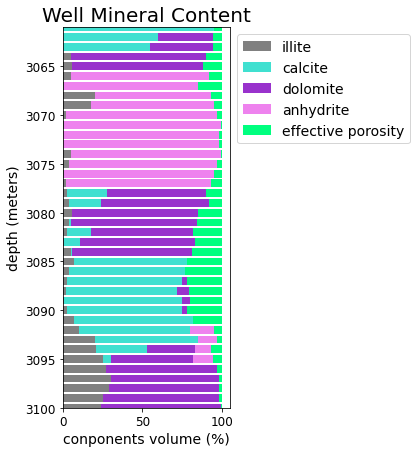

In [8]:
# нарисуем график

cal = np.array(cal_prop)
dol = np.array(dol_prop)
anh = np.array(anh_prop)
ill = np.array(ill_prop)
por = np.array(por_prop)

turquoise = '#40E0D0'
dark_violet = '#9932CC'
violet = '#EE82EE'
spring_green = '#00FF7F'

plt.figure(figsize = (3, 7))
plt.title('Well Mineral Content', fontsize = 20)

plt.barh(depth, ill, color = 'grey')
plt.barh(depth, cal, color = turquoise, left = ill)
plt.barh(depth, dol, color = dark_violet, left = cal + ill)
plt.barh(depth, anh, color = violet, left = dol + cal + ill)
plt.barh(depth, por, color = spring_green, left = anh + dol + cal + ill)
plt.xlabel('conponents volume (%)', fontsize = 14)
plt.ylabel('depth (meters)', fontsize = 14)

plt.ylim(max(depth), min(depth))

plt.legend(['illite', 'calcite', 'dolomite', 'anhydrite', 'effective porosity'], fontsize = 14,
          bbox_to_anchor=(1, 1))

plt.show()

In [9]:
# упругие модули
calcite = [70.8, 30.3]
dolomite = [80.2, 48.8]
anhydrite = [59.1, 31.4]
illite = [25.3, 16.3]

gas = [0.041, 0]
water = [2.496, 0]


# плотности
rho_components = [2.71, 2.87, 2.97, 2.52]

# Решение

## Прямая задача 

In [10]:
def do_forward_problem(get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA, get_moduli_by_DEM,
                       get_fluid_modulus_by_wood, get_saturated_by_gassman, get_velocity, props, porosity,
                       calcite = [70.8, 30.3], dolomite = [80.2, 48.8], anhydrite = [59.1, 31.4], illite = [25.3, 16.3],
                       water = [2.496, 0], gas = [0.041, 0], rho_components = [2.71, 2.87, 2.97, 2.52]):

    cal_prop, dol_prop, anh_prop, ill_prop = props[0], props[1], props[2], props[3]
    #print('этапы моделирования:')
    
    cal_dol = [0, 0]
    cal_dol_anh = [0, 0]
    cal_dol_anh_ill = [0, 0]
    
    # кальцит и доломит по Хашину-Штрикману
    if cal_prop == 0 and dol_prop == 0:
        cal_dol[0] = 0
        cal_dol[1] = 0
    elif cal_prop == 0:
        cal_dol[0] = dolomite[0]
        cal_dol[1] = dolomite[1]
    elif dol_prop == 0:
        cal_dol[0] = calcite[0]
        cal_dol[1] = calcite[1]
    else:
        proportion = round(get_proportion_for_HS(cal_prop, dol_prop))
        moduli = get_moduli_by_HS(get_HS_for_all_proportions, calcite, dolomite, proportion)
        cal_dol[0] = moduli[0]
        cal_dol[1] = moduli[1]
        #print('1. кальцит и доломит по Хашину-Штрикману:', cal_dol)
    
    
    # кальцит, доломит и ангидрит по Хашину-Штрикману
    if cal_prop == 0 and dol_prop == 0:
        cal_dol_anh[0] = anhydrite[0]
        cal_dol_anh[1] = anhydrite[1]
    elif anh_prop == 0:
        cal_dol_anh[0] = cal_dol[0]
        cal_dol_anh[1] = cal_dol[1]
    else:
        proportion = round(get_proportion_for_HS(anh_prop, cal_prop + dol_prop))
        moduli = get_moduli_by_HS(get_HS_for_all_proportions, anhydrite, cal_dol, proportion)
        cal_dol_anh[0] = moduli[0]
        cal_dol_anh[1] = moduli[1]
        #print('2. (кальцит+доломит) и ангидрит по Хашину-Штрикману:', cal_dol_anh)

        
    # кальцит, доломит, ангидрит + иллит по SCA
    if ill_prop == 0:
        cal_dol_anh_ill[0] = cal_dol_anh[0]
        cal_dol_anh_ill[1] = cal_dol_anh[1]
    else:
        proportion = round(get_proportion_for_HS(ill_prop, cal_prop + dol_prop + anh_prop))
        moduli = get_moduli_by_SCA(get_all_values_by_SCA, [illite[0], illite[1], 0.001],
                                        [cal_dol_anh[0], cal_dol_anh[1], 1], proportion)
        cal_dol_anh_ill[0] = moduli[0]
        cal_dol_anh_ill[1] = moduli[1]
        #print('3. (кальцит+доломит+ангидрит) и иллит по SCA:', cal_dol_anh_ill)

        
    # круглые поры в твердую матрицу по DEM
    matrix_pores = get_moduli_by_DEM(get_all_values_by_DEM, cal_dol_anh_ill, porosity)
    #print('4. круглые поры в твердую матрицу по DEM:', matrix_pores)
    
    # упругие модули флюида по Вуду
    fluid = get_fluid_modulus_by_wood(gas, water, 50)
    #print('5. упругие модули флюида:', fluid)

    # насытим поры флюидом
    saturated = get_saturated_by_gassman(matrix_pores, cal_dol_anh_ill, fluid, porosity)
    #print('6. готовая порода после насыщения пор флюидом:', saturated)
    #print()
    
    # рассчитаем скорости Vp и Vs
    rho_matrix = 0
    for i in range(len(rho_components)):
        rho_matrix += rho_components[i] * props[i] / 100

    rho_fluid = 1 * porosity / 100
    rho = rho_fluid + rho_matrix * (100 - porosity) / 100

    vp, vs = get_velocity(rho, saturated)


    return vp, vs

In [11]:
def get_velocities_in_well(do_forward_problem, cal_prop, dol_prop, anh_prop, ill_prop, por_prop):
    
    well_vp = []
    well_vs = []
    
    for i in range(len(cal_prop)):
        props = [cal_prop[i], dol_prop[i], anh_prop[i], ill_prop[i]]
        porosity = por_prop[i]
        
        vp_sample, vs_sample = do_forward_problem(get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA, 
                                                  get_moduli_by_DEM, get_fluid_modulus_by_wood, get_saturated_by_gassman, 
                                                  get_velocity, props, porosity)
        well_vp.append(vp_sample)
        well_vs.append(vs_sample)
    
    return well_vp, well_vs                                              

In [12]:
all_vp, all_vs = get_velocities_in_well(do_forward_problem, cal_prop, dol_prop, anh_prop, ill_prop, por_prop)

print(all_vp)
print()
print(all_vs)
print()
print(por_prop)

well_vp = np.array(all_vp)
well_vs = np.array(all_vs)

[6.274043230786054, 6.504261673453565, 6.540675777721003, 6.676878553169573, 6.597519506994734, 5.5977903573508865, 5.534903226298134, 5.312168840539104, 5.396134736295129, 5.74103300260048, 5.793869561246025, 5.797955573068971, 5.797955573068971, 5.714035148680771, 5.7017214232961635, 5.726982097329433, 5.67227446917456, 6.572075388459291, 6.623575269624648, 6.531992215449216, 6.577104053162119, 6.419170145302844, 6.619994319520096, 6.464866594453619, 5.560774311213939, 5.619212397553356, 5.704839236896742, 5.798928221792253, 5.858962371856694, 5.704839236896742, 5.680845187257207, 5.888016762729903, 5.705603409164872, 5.787054400772071, 5.853342641954445, 6.044996285746547, 5.9680112163389, 5.997936876998311, 6.120233324087969, 6.200616016665958]

[3.3186190972625003, 3.5724956568734836, 3.6094824005896795, 3.906647454662694, 3.8666116136326485, 3.1666055369075012, 3.1502377595338054, 3.0327086290466023, 3.068588286975478, 3.219849735977796, 3.2381666462052343, 3.2423147130634904, 3.

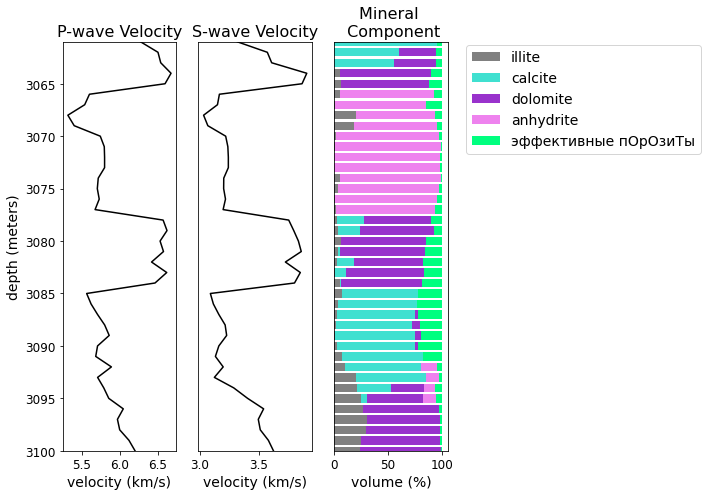

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 7))

axes[2].barh(depth, ill, color = 'grey')
axes[2].barh(depth, cal, color = turquoise, left = ill)
axes[2].barh(depth, dol, color = dark_violet, left = cal + ill)
axes[2].barh(depth, anh, color = violet, left = dol + cal + ill)
axes[2].barh(depth, por, color = spring_green, left = anh + dol + cal + ill)
axes[2].set_ylim(bottom = max(depth), top = min(depth))
axes[2].legend(['illite', 'calcite', 'dolomite', 'anhydrite', 'эффективные пОрОзиТы'], fontsize = 14, 
               bbox_to_anchor=(1.1, 1.01))
axes[2].yaxis.set_visible(False)
axes[2].set_title('Mineral \n Component', fontsize = 16)
axes[2].set_xlabel('volume (%)', fontsize = 14)

axes[0].plot(well_vp, depth, c = 'k')
axes[0].set_ylim(bottom = max(depth), top = min(depth))
axes[0].set_title('P-wave Velocity', fontsize = 16)
axes[0].set_xlabel('velocity (km/s)', fontsize = 14)
axes[0].set_ylabel('depth (meters)', fontsize = 14)

axes[1].plot(well_vs, depth, c = 'k')
axes[1].set_ylim(bottom = max(depth), top = min(depth))
axes[1].yaxis.set_visible(False)
axes[1].set_title('S-wave Velocity', fontsize = 16)
axes[1].set_xlabel('velocity (km/s)', fontsize = 14)

fig.tight_layout()

## Обратная задача 

In [14]:
def do_forward_problem_matrix(get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA, get_moduli_by_DEM,
                       get_fluid_modulus_by_wood, get_saturated_by_gassman, get_velocity, props,
                       calcite = [70.8, 30.3], dolomite = [80.2, 48.8], anhydrite = [59.1, 31.4], illite = [25.3, 16.3],
                       water = [2.496, 0], gas = [0.041, 0], rho_components = [2.71, 2.87, 2.97, 2.52]):

    cal_prop, dol_prop, anh_prop, ill_prop = props[0], props[1], props[2], props[3]
    #print('этапы моделирования:')
    
    cal_dol = [0, 0]
    cal_dol_anh = [0, 0]
    cal_dol_anh_ill = [0, 0]
    
    # кальцит и доломит по Хашину-Штрикману
    if cal_prop == 0 and dol_prop == 0:
        cal_dol[0] = 0
        cal_dol[1] = 0
    elif cal_prop == 0:
        cal_dol[0] = dolomite[0]
        cal_dol[1] = dolomite[1]
    elif dol_prop == 0:
        cal_dol[0] = calcite[0]
        cal_dol[1] = calcite[1]
    else:
        proportion = round(get_proportion_for_HS(cal_prop, dol_prop))
        moduli = get_moduli_by_HS(get_HS_for_all_proportions, calcite, dolomite, proportion)
        cal_dol[0] = moduli[0]
        cal_dol[1] = moduli[1]
        #print('1. кальцит и доломит по Хашину-Штрикману:', cal_dol)
    
    
    # кальцит, доломит и ангидрит по Хашину-Штрикману
    if cal_prop == 0 and dol_prop == 0:
        cal_dol_anh[0] = anhydrite[0]
        cal_dol_anh[1] = anhydrite[1]
    elif anh_prop == 0:
        cal_dol_anh[0] = cal_dol[0]
        cal_dol_anh[1] = cal_dol[1]
    else:
        proportion = round(get_proportion_for_HS(anh_prop, cal_prop + dol_prop))
        moduli = get_moduli_by_HS(get_HS_for_all_proportions, anhydrite, cal_dol, proportion)
        cal_dol_anh[0] = moduli[0]
        cal_dol_anh[1] = moduli[1]
        #print('2. (кальцит+доломит) и ангидрит по Хашину-Штрикману:', cal_dol_anh)

        
    # кальцит, доломит, ангидрит + иллит по SCA
    if ill_prop == 0:
        cal_dol_anh_ill[0] = cal_dol_anh[0]
        cal_dol_anh_ill[1] = cal_dol_anh[1]
    else:
        proportion = round(get_proportion_for_HS(ill_prop, cal_prop + dol_prop + anh_prop))
        moduli = get_moduli_by_SCA(get_all_values_by_SCA, [illite[0], illite[1], 0.001],
                                        [cal_dol_anh[0], cal_dol_anh[1], 1], proportion)
        cal_dol_anh_ill[0] = moduli[0]
        cal_dol_anh_ill[1] = moduli[1]
        #print('3. (кальцит+доломит+ангидрит) и иллит по SCA:', cal_dol_anh_ill)

        
    # упругие модули флюида по Вуду
    fluid = get_fluid_modulus_by_wood(gas, water, 50)

    rho_matrix = 0
    for i in range(len(rho_components)):
        rho_matrix += rho_components[i] * props[i] / 100


    return cal_dol_anh_ill, fluid, rho_matrix



def do_forward_problem_pores_fast(get_moduli_by_DEM, get_saturated_by_gassman, cal_dol_anh_ill, fluid, rho_matrix, porosity):
    # круглые поры в твердую матрицу по DEM
    matrix_pores = get_moduli_by_DEM(get_all_values_by_DEM, cal_dol_anh_ill, porosity)

    # насытим поры флюидом
    saturated = get_saturated_by_gassman(matrix_pores, cal_dol_anh_ill, fluid, porosity)

    # рассчитаем скорости Vp и Vs
    rho_fluid = 1
    rho = rho_matrix * (1 - porosity/100) + rho_fluid * porosity/100
    k, g = saturated[0], saturated[1]

    vp = math.sqrt((k + g * 4 / 3) / rho)
    vs = math.sqrt(g / rho)

    return vp, vs

## Монте-Карло 

In [15]:
def check_how_close(vp_true, vs_true, vp_sample, vs_sample, allowable_error):
    error = math.sqrt((vp_true - vp_sample)**2 + (vs_true - vs_sample)**2)
    if error < allowable_error:
        return True
    else:
        return False
    

    
def do_monte_carlo(do_forward_problem_pores_fast, get_moduli_by_DEM, get_saturated_by_gassman, 
                   check_how_close, cal_dol_anh_ill, fluid, rho_matrix, vp_true, vs_true, N, allowable_error):
    
    por_np = np.around((np.random.random(N)) * 30, decimals = 1)
    por = por_np.tolist()
    
    vs = []
    vp = []
    good_por = []

    for i in range(len(por)):
        porosity = por[i]
        vp_sample, vs_sample = do_forward_problem_pores_fast(get_moduli_by_DEM, get_saturated_by_gassman, 
                                                               cal_dol_anh_ill, fluid, rho_matrix, porosity)
    
        check = check_how_close(vp_true, vs_true, vp_sample, vs_sample, allowable_error)
        

        if check == True:
            vp.append(vp_sample)
            vs.append(vs_sample)
            good_por.append(por[i])

    avg_por = sum(good_por) / len(good_por)
    
    return avg_por

In [16]:
from time import time

def do_inverse_problem(do_monte_carlo, cal_prop, dol_prop, anh_prop, ill_prop, well_vp, well_vs, N = 100, allowable_error = 0.1):
    
    all_por = []
    
    start = time()
    for i in range(len(well_vp)):
        
        print('отсчет', i)
        
        props = [cal_prop[i], dol_prop[i], anh_prop[i], ill_prop[i]]
        porosity = por_prop[i]
        
        vp_true = well_vp[i]
        vs_true = well_vs[i]
        
        cal_dol_anh_ill, fluid, rho_matrix = do_forward_problem_matrix(get_proportion_for_HS, get_moduli_by_HS, 
                        get_moduli_by_SCA, get_moduli_by_DEM, get_fluid_modulus_by_wood, get_saturated_by_gassman, 
                        get_velocity, props, calcite = [70.8, 30.3], dolomite = [80.2, 48.8], 
                        anhydrite = [59.1, 31.4], illite = [25.3, 16.3], water = [2.496, 0], gas = [0.041, 0], 
                        rho_components = [2.71, 2.87, 2.97, 2.52])
        
        avg_por = do_monte_carlo(do_forward_problem_pores_fast, get_moduli_by_DEM, get_saturated_by_gassman, 
                                 check_how_close, cal_dol_anh_ill, fluid, rho_matrix, vp_true, vs_true, N, allowable_error)
        
        all_por.append(avg_por)
        
        print()
        print('real_por', porosity)
        print('avg_por', avg_por)
        print()
        
        print("vp true", vp_true)
        vp_final, vs_final = do_forward_problem(get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA, 
                                                  get_moduli_by_DEM, get_fluid_modulus_by_wood, get_saturated_by_gassman, 
                                                  get_velocity, props, avg_por)
        print('vp_mc', vp_final)
        print()
        print()
        
    end = time()
    
    return(all_por, end - start)

In [17]:
new_cal_prop = cal_prop[:20]
new_dol_prop = dol_prop[:20]
new_ill_prop = ill_prop[:20]
new_anh_prop = anh_prop[:20]
new_well_vp = well_vp[:20]
new_well_vs = well_vs[:20]

print(new_cal_prop)

[95, 60, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 20, 0]


In [18]:
all_por, time = do_inverse_problem(do_monte_carlo, cal_prop, dol_prop, anh_prop, ill_prop, 
                                   well_vp, well_vs, N = 50, allowable_error = 0.1)

отсчет 0

real_por 5
avg_por 5.5

vp true 6.274043230786054
vp_mc 6.244488458743283


отсчет 1

real_por 6
avg_por 5.960000000000001

vp true 6.504261673453565
vp_mc 6.503430301624801


отсчет 2

real_por 6
avg_por 6.385714285714285

vp true 6.540675777721003
vp_mc 6.517507297394281


отсчет 3

real_por 10
avg_por 10.225

vp true 6.676878553169573
vp_mc 6.666265298295312


отсчет 4

real_por 12
avg_por 12.22857142857143

vp true 6.597519506994734
vp_mc 6.586770237344376


отсчет 5

real_por 8
avg_por 8.866666666666667

vp true 5.5977903573508865
vp_mc 5.554385727482833


отсчет 6

real_por 15
avg_por 14.669999999999998

vp true 5.534903226298134
vp_mc 5.549901197111138


отсчет 7


C:\Users\vdvor\AppData\Local\Temp\ipykernel_13932\2442634881.py:37: RuntimeWarning: invalid value encountered in double_scalars
  k_sat = k_dry + (1 - k_dry / k_m) ** 2 / (porosity / k_fl + (1 - porosity) / k_m - k_dry / k_m ** 2)



real_por 7
avg_por 7.333333333333333

vp true 5.312168840539104
vp_mc 5.2995535241826985


отсчет 8

real_por 5
avg_por 5.3125

vp true 5.396134736295129
vp_mc 5.3832705483621845


отсчет 9

real_por 3
avg_por 2.9499999999999997

vp true 5.74103300260048
vp_mc 5.746580130542517


отсчет 10

real_por 1
avg_por 1.8333333333333333

vp true 5.793869561246025
vp_mc 5.758209880981205


отсчет 11

real_por 2
avg_por 0.4000000000000001

vp true 5.797955573068971
vp_mc 5.871416505367212


отсчет 12

real_por 2
avg_por 1.5142857142857142

vp true 5.797955573068971
vp_mc 5.821201885065799


отсчет 13

real_por 1
avg_por 1.8399999999999999

vp true 5.714035148680771
vp_mc 5.679148144766846


отсчет 14

real_por 3
avg_por 3.057142857142857

vp true 5.7017214232961635
vp_mc 5.696358433191841


отсчет 15

real_por 5
avg_por 5.090909090909091

vp true 5.726982097329433
vp_mc 5.722111462598602


отсчет 16

real_por 7
avg_por 8.075

vp true 5.67227446917456
vp_mc 5.619352133233836


отсчет 17

real_por

In [19]:
print('time (s):', time)
print()
print(all_por)

time (s): 416.5277659893036

[5.5, 5.960000000000001, 6.385714285714285, 10.225, 12.22857142857143, 8.866666666666667, 14.669999999999998, 7.333333333333333, 5.3125, 2.9499999999999997, 1.8333333333333333, 0.4000000000000001, 1.5142857142857142, 1.8399999999999999, 3.057142857142857, 5.090909090909091, 8.075, 9.683333333333332, 7.666666666666667, 14.899999999999999, 15.5, 17.4, 17.150000000000002, 18.6, 21.7, 23.450000000000003, 21.78, 21.140000000000004, 20.22, 22.566666666666666, 17.82, 4.2, 2.1999999999999997, 7.171428571428572, 6.08, 2.425, 1.5625, 1.4833333333333334, 1.775, 1.14]


In [20]:
all_vp_mc, all_vs_mc = get_velocities_in_well(do_forward_problem, cal_prop, dol_prop, anh_prop, ill_prop, 
                                              all_por)

print(all_vp_mc)
print()
print(all_vs_mc)

[6.244488458743283, 6.503430301624801, 6.517507297394281, 6.666265298295312, 6.586770237344376, 5.554385727482833, 5.549901197111138, 5.2995535241826985, 5.3832705483621845, 5.746580130542517, 5.758209880981205, 5.871416505367212, 5.821201885065799, 5.679148144766846, 5.696358433191841, 5.722111462598602, 5.619352133233836, 6.588881379075998, 6.639521533557296, 6.537882403203009, 6.6072538079405145, 6.456414226193396, 6.606410578828341, 6.489784691234611, 5.579618232138536, 5.5859667145839, 5.7174255131066225, 5.793184125525712, 5.846383486707342, 5.665495914490125, 5.69331267342463, 5.930023625059599, 5.7446415233954085, 5.776759800986813, 5.848302042074827, 6.072829388172928, 5.985059174448852, 6.019927981824176, 6.128853979298949, 6.196853490398892]

[3.3072118047244943, 3.5720389905047303, 3.599125283469701, 3.9009673044476676, 3.8608264249075828, 3.1455719145404397, 3.1576070434608323, 3.0264771271985205, 3.062296853017774, 3.222529835244173, 3.221760323081652, 3.2761299807605657,

In [21]:
def draw_MC_plots(depth, ill, cal, dol, anh, por, well_vp, well_vs, all_vp_mc, all_vs_mc, title):

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 7))
    fig.suptitle(title, fontsize = 12)

    axes[3].barh(depth, ill, color = 'grey')
    axes[3].barh(depth, cal, color = turquoise, left = ill)
    axes[3].barh(depth, dol, color = dark_violet, left = cal + ill)
    axes[3].barh(depth, anh, color = violet, left = dol + cal + ill)
    axes[3].barh(depth, por, color = spring_green, left = anh + dol + cal + ill)
    axes[3].set_ylim(bottom = max(depth), top = min(depth))
    axes[3].legend(['illite', 'calcite', 'dolomite', 'anhydrite', 'эффективные пОрОзиТы'], fontsize = 14, 
                   bbox_to_anchor=(1.1, 1.01))
    axes[3].yaxis.set_visible(False)
    axes[3].set_title('Mineral Component', fontsize = 15)
    axes[3].set_xlabel('volume (%)', fontsize = 13)

    axes[0].plot(well_vp, depth, c = 'k')
    axes[0].plot(all_vp_mc, depth, c = 'r', linestyle = '--')
    axes[0].set_ylim(bottom = max(depth), top = min(depth))
    axes[0].set_title('P-wave Velocity', fontsize = 15)
    axes[0].set_xlabel('velocity (km/s)', fontsize = 13)
    axes[0].set_ylabel('depth (meters)', fontsize = 13)
    axes[0].legend(['forward modeling', 'inverse modeling'], fontsize = 14, bbox_to_anchor=(6.25, 0.7))

    axes[1].plot(well_vs, depth, c = 'k')
    axes[1].plot(all_vs_mc, depth, c = 'r', linestyle = '--')
    axes[1].set_ylim(bottom = max(depth), top = min(depth))
    axes[1].yaxis.set_visible(False)
    axes[1].set_title('S-wave Velocity', fontsize = 15)
    axes[1].set_xlabel('velocity (km/s)', fontsize = 13)
    
    axes[2].plot(por_prop, depth, c = 'k')
    axes[2].plot(all_por, depth, c = 'r', linestyle = '--')
    axes[2].set_ylim(bottom = max(depth), top = min(depth))
    axes[2].yaxis.set_visible(False)
    axes[2].set_title('Effective Porosity', fontsize = 15)
    axes[2].set_xlabel('porosity (%)', fontsize = 13)

    fig.tight_layout()

C:\Users\vdvor\AppData\Local\Temp\ipykernel_13932\3971197214.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


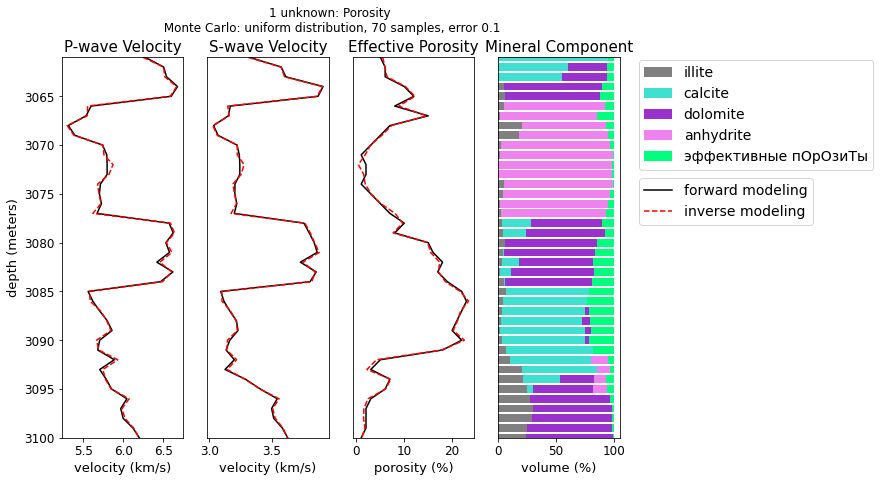

In [22]:
draw_MC_plots(depth, ill, cal, dol, anh, por, well_vp, well_vs, all_vp_mc, all_vs_mc, 
             title = "1 unknown: Porosity \n Monte Carlo: uniform distribution, 70 samples, error 0.1 \n")

In [26]:
# испортим скважину
def spoil_the_well(cal_prop, dol_prop, anh_prop, ill_prop, por_prop, well_error):
    
    cal_prop_err = []
    dol_prop_err = []
    anh_prop_err = []
    ill_prop_err = []
    por_prop_err = []
    
    for i in range(len(cal_prop)):
        cal = cal_prop[i] + np.random.randint(0, well_error)
        dol = dol_prop[i] + np.random.randint(0, well_error)
        anh = anh_prop[i] + np.random.randint(0, well_error)
        ill = ill_prop[i] + np.random.randint(0, well_error)
        por = por_prop[i] + np.random.randint(0, well_error)
        
        all_components = cal + dol + anh + ill + por
        
        
        # нормируем 
        cal = round(cal / all_components * 100)
        dol = round(dol / all_components * 100)
        anh = round(anh / all_components * 100)
        ill = round(ill / all_components * 100)
        por = round(por / all_components * 100)
        
        all_components = cal + dol + anh + ill + por
        
        if all_components == 99:
            cal += 1
        elif all_components ==101:
            por -= 1
            
        cal_prop_err.append(cal)
        dol_prop_err.append(dol)
        anh_prop_err.append(anh)
        ill_prop_err.append(ill)
        por_prop_err.append(por)
        
    return cal_prop_err, dol_prop_err, anh_prop_err, ill_prop_err, por_prop_err

In [27]:
cal_prop_3, dol_prop_3, anh_prop_3, ill_prop_3, por_prop_3 = spoil_the_well(cal_prop, dol_prop, 
                                                                        anh_prop, ill_prop, por_prop, well_error = 3)

cal_prop_10, dol_prop_10, anh_prop_10, ill_prop_10, por_prop_10 = spoil_the_well(cal_prop, dol_prop, 
                                                                        anh_prop, ill_prop, por_prop, well_error = 10)

cal_prop_15, dol_prop_15, anh_prop_15, ill_prop_15, por_prop_15 = spoil_the_well(cal_prop, dol_prop, 
                                                                        anh_prop, ill_prop, por_prop, well_error = 15)

cal_prop_20, dol_prop_20, anh_prop_20, ill_prop_20, por_prop_20 = spoil_the_well(cal_prop, dol_prop, 
                                                                        anh_prop, ill_prop, por_prop, well_error = 20)

cal_prop_30, dol_prop_30, anh_prop_30, ill_prop_30, por_prop_30 = spoil_the_well(cal_prop, dol_prop, 
                                                                        anh_prop, ill_prop, por_prop, well_error = 30)

In [25]:
error_0 = [cal_prop, dol_prop, anh_prop, ill_prop, por_prop]
error_3 = [cal_prop_3, dol_prop_3, anh_prop_3, ill_prop_3, por_prop_3]
error_10 = [cal_prop_10, dol_prop_10, anh_prop_10, ill_prop_10, por_prop_10]
error_15 = [cal_prop_15, dol_prop_15, anh_prop_15, ill_prop_15, por_prop_15]
error_20 = [cal_prop_20, dol_prop_20, anh_prop_20, ill_prop_20, por_prop_20]
error_30 = [cal_prop_30, dol_prop_30, anh_prop_30, ill_prop_30, por_prop_30]

error_mineral_columns = [error_0, error_3, error_10, error_15, error_20, error_30]

In [77]:
def draw_mineral_columns(error_mineral_columns, depth, title):
    
    fig, axes = plt.subplots(nrows = 1, ncols = len(error_mineral_columns), figsize = (14, 7))
    fig.suptitle(title, fontsize = 18)
    
    
    for i in range(len(error_mineral_columns)):
        error = error_mineral_columns[i]
        
        cal = np.array(error[0])
        dol = np.array(error[1])
        anh = np.array(error[2])
        ill = np.array(error[3])
        por = np.array(error[4])
    
        axes[i].barh(depth, ill, color = 'grey')
        axes[i].barh(depth, cal, color = turquoise, left = ill)
        axes[i].barh(depth, dol, color = dark_violet, left = cal + ill)
        axes[i].barh(depth, anh, color = violet, left = dol + cal + ill)
        axes[i].barh(depth, por, color = spring_green, left = anh + dol + cal + ill)
        axes[i].set_ylim(bottom = max(depth), top = min(depth))
        axes[i].yaxis.set_visible(False)
    
    axes[0].yaxis.set_visible(True)
    axes[-1].yaxis.set_visible(True)
    axes[-1].yaxis.tick_right()
    
    
    axes[0].legend(['illite', 'calcite', 'dolomite', 'anhydrite', 'эффективные пОрОзиТы'], fontsize = 14,
                   loc = 'upper center', bbox_to_anchor=(3.4, -0.07), fancybox=True, shadow=True, ncol=6)
    
    
    axes[0].set_title('Ideal Well', fontsize = 15)
    axes[1].set_title('3% Error', fontsize = 15)
    axes[2].set_title('10% Error', fontsize = 15)
    axes[3].set_title('15% Error', fontsize = 15)
    axes[4].set_title('20% Error', fontsize = 15)
    axes[5].set_title('30% Error', fontsize = 15)

    fig.tight_layout()

C:\Users\vdvor\AppData\Local\Temp\ipykernel_13932\3218066046.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


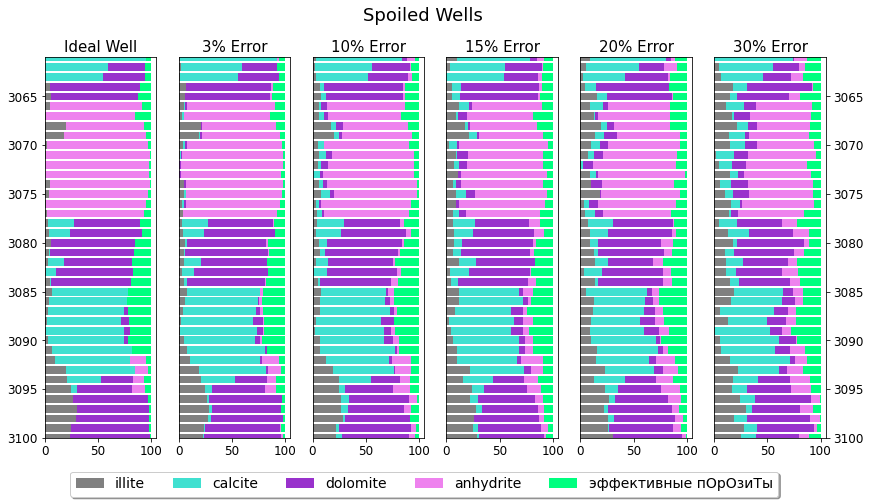

In [78]:
draw_mineral_columns(error_mineral_columns, depth, title = 'Spoiled Wells')

In [80]:
# решим прямую задачу для всех скважин

all_vp_3, all_vs_3 = get_velocities_in_well(do_forward_problem, cal_prop_3, dol_prop_3, anh_prop_3, ill_prop_3, por_prop_3)
all_vp_10, all_vs_10 = get_velocities_in_well(do_forward_problem, cal_prop_10, dol_prop_10, anh_prop_10, ill_prop_10, 
                                              por_prop_10)
all_vp_15, all_vs_15 = get_velocities_in_well(do_forward_problem, cal_prop_15, dol_prop_15, anh_prop_15, ill_prop_15, 
                                              por_prop_15)
all_vp_20, all_vs_20 = get_velocities_in_well(do_forward_problem, cal_prop_20, dol_prop_20, anh_prop_20, ill_prop_20, 
                                              por_prop_20)
all_vp_30, all_vs_30 = get_velocities_in_well(do_forward_problem, cal_prop_30, dol_prop_30, anh_prop_30, ill_prop_30, 
                                              por_prop_30)

error_0 = [np.array(all_vp), np.array(all_vs)]
error_3 = [np.array(all_vp_3), np.array(all_vs_3)]
error_10 = [np.array(all_vp_10), np.array(all_vs_10)]
error_15 = [np.array(all_vp_15), np.array(all_vs_15)]
error_20 = [np.array(all_vp_20), np.array(all_vs_20)]
error_30 = [np.array(all_vp_30), np.array(all_vs_30)]

error_velocities = [error_0, error_3, error_10, error_15, error_20, error_30]

In [100]:
def draw_velocities_for_spoiled_wells(depth, error_velocities, ill, cal, dol, anh, por):

    ffig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 7))
    #fig.suptitle(title, fontsize = 12)

    # скорость Vp
    axes[0].plot(error_velocities[0][0], depth, c = 'k')
    axes[0].plot(error_velocities[1][0], depth, c = '#87CEFA')
    axes[0].plot(error_velocities[2][0], depth, c = '#1E90FF')
    axes[0].plot(error_velocities[3][0], depth, c = '#0000FF')
    axes[0].plot(error_velocities[4][0], depth, c = '#000080')
    axes[0].plot(error_velocities[5][0], depth, c = '#483D8B')
    
    axes[0].set_ylim(bottom = max(depth), top = min(depth))
    axes[0].set_title('P-wave Velocity', fontsize = 15)
    axes[0].set_xlabel('velocity (km/s)', fontsize = 13)
    axes[0].set_ylabel('depth (meters)', fontsize = 13)
    axes[0].legend(['ideal', '3% error', '10% error', '15% error', '20% error', '30% error'], fontsize = 14, 
                   bbox_to_anchor=(4.32, 0.7))

    
    # скорость Vs
    axes[1].plot(error_velocities[0][1], depth, c = 'k')
    axes[1].plot(error_velocities[1][1], depth, c = '#87CEFA')
    axes[1].plot(error_velocities[2][1], depth, c = '#1E90FF')
    axes[1].plot(error_velocities[3][1], depth, c = '#0000FF')
    axes[1].plot(error_velocities[4][1], depth, c = '#000080')
    axes[1].plot(error_velocities[5][1], depth, c = '#483D8B')
    
    axes[1].set_ylim(bottom = max(depth), top = min(depth))
    axes[1].yaxis.set_visible(False)
    axes[1].set_title('S-wave Velocity', fontsize = 15)
    axes[1].set_xlabel('velocity (km/s)', fontsize = 13)
    
    
    axes[2].barh(depth, ill, color = 'grey')
    axes[2].barh(depth, cal, color = turquoise, left = ill)
    axes[2].barh(depth, dol, color = dark_violet, left = cal + ill)
    axes[2].barh(depth, anh, color = violet, left = dol + cal + ill)
    axes[2].barh(depth, por, color = spring_green, left = anh + dol + cal + ill)
    axes[2].set_ylim(bottom = max(depth), top = min(depth))
    axes[2].legend(['illite', 'calcite', 'dolomite', 'anhydrite', 'эффективные пОрОзиТы'], fontsize = 14, 
                   bbox_to_anchor=(1.1, 1.01))
    axes[2].yaxis.set_visible(False)
    axes[2].set_title('Mineral Component', fontsize = 15)
    axes[2].set_xlabel('volume (%)', fontsize = 13)

    fig.tight_layout()

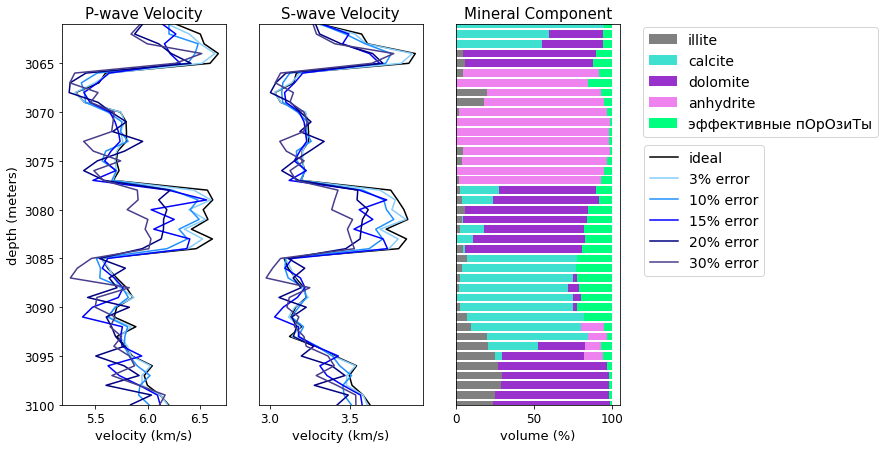

In [101]:
draw_velocities_for_spoiled_wells(depth, error_velocities, ill, cal, dol, anh, por)

In [103]:
from time import time

def do_inverse_problem(do_monte_carlo, cal_prop, dol_prop, anh_prop, ill_prop, well_vp, well_vs, N = 100, allowable_error = 0.1):
    
    all_por = []
    
    start = time()
    for i in range(len(well_vp)):
        
        print('отсчет', i)
        
        props = [cal_prop[i], dol_prop[i], anh_prop[i], ill_prop[i]]
        porosity = por_prop[i]
        
        vp_true = well_vp[i]
        vs_true = well_vs[i]
        
        cal_dol_anh_ill, fluid, rho_matrix = do_forward_problem_matrix(get_proportion_for_HS, get_moduli_by_HS, 
                        get_moduli_by_SCA, get_moduli_by_DEM, get_fluid_modulus_by_wood, get_saturated_by_gassman, 
                        get_velocity, props, calcite = [70.8, 30.3], dolomite = [80.2, 48.8], 
                        anhydrite = [59.1, 31.4], illite = [25.3, 16.3], water = [2.496, 0], gas = [0.041, 0], 
                        rho_components = [2.71, 2.87, 2.97, 2.52])
        
        avg_por = do_monte_carlo(do_forward_problem_pores_fast, get_moduli_by_DEM, get_saturated_by_gassman, 
                                 check_how_close, cal_dol_anh_ill, fluid, rho_matrix, vp_true, vs_true, N, allowable_error)
        
        all_por.append(avg_por)
        
        print()
        print('real_por', porosity)
        print('avg_por', avg_por)
        print()
        
        print("vp true", vp_true)
        vp_final, vs_final = do_forward_problem(get_proportion_for_HS, get_moduli_by_HS, get_moduli_by_SCA, 
                                                  get_moduli_by_DEM, get_fluid_modulus_by_wood, get_saturated_by_gassman, 
                                                  get_velocity, props, avg_por)
        print('vp_mc', vp_final)
        print()
        print()
        
    end = time()
    
    return(all_por, end - start)

In [104]:
all_por_3, time_3 = do_inverse_problem(do_monte_carlo, cal_prop_3, dol_prop_3, anh_prop_3, ill_prop_3, 
                                   all_vp_3, all_vs_3, N = 50, allowable_error = 0.15)

отсчет 0

real_por 5
avg_por 7.242857142857143

vp true 6.197237014022222
vp_mc 6.128272271072686


отсчет 1

real_por 6
avg_por 7.044444444444443

vp true 6.398552297836574
vp_mc 6.399460544733529


отсчет 2

real_por 6
avg_por 5.300000000000001

vp true 6.504336786260915
vp_mc 6.543862170718272


отсчет 3

real_por 10
avg_por 11.4875

vp true 6.643943269515048
vp_mc 6.615480886448949


отсчет 4

real_por 12
avg_por 11.47

vp true 6.51916806440252
vp_mc 6.490870811892054


отсчет 5

real_por 8
avg_por 6.318181818181819

vp true 5.636880363675675
vp_mc 5.670218600298439


отсчет 6

real_por 15
avg_por 14.350000000000001

vp true 5.498122413657812
vp_mc 5.528002127958669


отсчет 7

real_por 7
avg_por 9.684615384615382

vp true 5.306195451678694
vp_mc 5.274223093269798


отсчет 8

real_por 5
avg_por 5.076923076923077

vp true 5.396609107666618
vp_mc 5.391840565507996


отсчет 9

real_por 3
avg_por 4.05

vp true 5.745143535762732
vp_mc 5.739529589178945


отсчет 10

real_por 1
avg_por 2.

C:\Users\vdvor\AppData\Local\Temp\ipykernel_13932\2442634881.py:37: RuntimeWarning: invalid value encountered in double_scalars
  k_sat = k_dry + (1 - k_dry / k_m) ** 2 / (porosity / k_fl + (1 - porosity) / k_m - k_dry / k_m ** 2)



real_por 8
avg_por 7.4799999999999995

vp true 6.605683881711617
vp_mc 6.632986392300697


отсчет 19

real_por 15
avg_por 16.86

vp true 6.3953888327278285
vp_mc 6.34174543622607


отсчет 20

real_por 16
avg_por 17.025

vp true 6.552904769463549
vp_mc 6.553429272733922


отсчет 21

real_por 18
avg_por 16.91111111111111

vp true 6.3514682489101535
vp_mc 6.357732241182977


отсчет 22

real_por 17
avg_por 16.571428571428573

vp true 6.526767069853816
vp_mc 6.48972783347826


отсчет 23

real_por 19
avg_por 17.41

vp true 6.384163942915001
vp_mc 6.360439282246328


отсчет 24

real_por 22
avg_por 21.85

vp true 5.5552874705509145
vp_mc 5.560700875796229


отсчет 25

real_por 23
avg_por 22.771428571428572

vp true 5.630882621930117
vp_mc 5.643320377935854


отсчет 26

real_por 22
avg_por 22.08

vp true 5.683464461811346
vp_mc 5.676711560775442


отсчет 27

real_por 21
avg_por 21.480000000000004

vp true 5.734205427718336
vp_mc 5.766004274880887


отсчет 28

real_por 20
avg_por 19.84

vp true

In [105]:
all_por_10, time_10 = do_inverse_problem(do_monte_carlo, cal_prop_10, dol_prop_10, anh_prop_10, ill_prop_10, 
                                   all_vp_10, all_vs_10, N = 50, allowable_error = 0.15)

отсчет 0

real_por 5
avg_por 6.944444444444444

vp true 6.204192493776157
vp_mc 6.152923883971101


отсчет 1

real_por 6
avg_por 10.35

vp true 6.204777573260575
vp_mc 6.245727373007393


отсчет 2

real_por 6
avg_por 8.333333333333334

vp true 6.483626312061362
vp_mc 6.46695997118676


отсчет 3


C:\Users\vdvor\AppData\Local\Temp\ipykernel_13932\2442634881.py:37: RuntimeWarning: invalid value encountered in double_scalars
  k_sat = k_dry + (1 - k_dry / k_m) ** 2 / (porosity / k_fl + (1 - porosity) / k_m - k_dry / k_m ** 2)



real_por 10
avg_por 14.540000000000001

vp true 6.453816106021165
vp_mc 6.425632748874732


отсчет 4

real_por 12
avg_por 11.525

vp true 6.38439967868231
vp_mc 6.3576213158481485


отсчет 5

real_por 8
avg_por 6.5

vp true 5.51883008711537
vp_mc 5.541929593887093


отсчет 6

real_por 15
avg_por 18.125

vp true 5.366818272062075
vp_mc 5.362017695461264


отсчет 7

real_por 7
avg_por 5.454545454545454

vp true 5.396279899199911
vp_mc 5.417591342237497


отсчет 8

real_por 5
avg_por 9.12

vp true 5.407109491190116
vp_mc 5.402829546829225


отсчет 9

real_por 3
avg_por 9.166666666666666

vp true 5.620605210676857
vp_mc 5.610254160720403


отсчет 10

real_por 1
avg_por 5.25

vp true 5.754659314460749
vp_mc 5.7461769759203305


отсчет 11

real_por 2
avg_por 6.5

vp true 5.742131158748954
vp_mc 5.766381679166331


отсчет 12

real_por 2
avg_por 3.945454545454545

vp true 5.813797477626867
vp_mc 5.819401404060845


отсчет 13

real_por 1
avg_por 7.855555555555556

vp true 5.5995626687914815
vp

In [106]:
all_por_15, time_15 = do_inverse_problem(do_monte_carlo, cal_prop_15, dol_prop_15, anh_prop_15, ill_prop_15, 
                                   all_vp_15, all_vs_15, N = 50, allowable_error = 0.15)

отсчет 0

real_por 5
avg_por 6.133333333333333

vp true 6.144161562592963
vp_mc 6.195813127866202


отсчет 1

real_por 6
avg_por 11.2125

vp true 6.270358085794049
vp_mc 6.258989094231541


отсчет 2

real_por 6
avg_por 8.425

vp true 6.161604874026336
vp_mc 6.140498151593479


отсчет 3

real_por 10
avg_por 11.45

vp true 6.2151477525076
vp_mc 6.194821881390991


отсчет 4

real_por 12
avg_por 16.818181818181817

vp true 6.312340175714383
vp_mc 6.324579082203188


отсчет 5

real_por 8
avg_por 12.29

vp true 5.632417456945425
vp_mc 5.668094817280699


отсчет 6

real_por 15
avg_por 17.625

vp true 5.52223421172125
vp_mc 5.544383599864625


отсчет 7

real_por 7
avg_por 10.761538461538462

vp true 5.390930924134351
vp_mc 5.353112325574041


отсчет 8

real_por 5
avg_por 3.723076923076923

vp true 5.449212176491318
vp_mc 5.462659762766942


отсчет 9

real_por 3
avg_por 10.425

vp true 5.63974683422285
vp_mc 5.620389480753998


отсчет 10

real_por 1
avg_por 4.741666666666666

vp true 5.68874742

C:\Users\vdvor\AppData\Local\Temp\ipykernel_13932\2442634881.py:37: RuntimeWarning: invalid value encountered in double_scalars
  k_sat = k_dry + (1 - k_dry / k_m) ** 2 / (porosity / k_fl + (1 - porosity) / k_m - k_dry / k_m ** 2)



real_por 2
avg_por 3.3666666666666667

vp true 5.720719437358637
vp_mc 5.747793104715057


отсчет 12

real_por 2
avg_por 7.137500000000001

vp true 5.7370282503475245
vp_mc 5.78191027744229


отсчет 13

real_por 1
avg_por 6.925

vp true 5.650007771548596
vp_mc 5.608244833320455


отсчет 14

real_por 3
avg_por 7.91111111111111

vp true 5.589865812801161
vp_mc 5.5948454167483765


отсчет 15

real_por 5
avg_por 6.849999999999999

vp true 5.695795002135812
vp_mc 5.7062490082761546


отсчет 16

real_por 7
avg_por 14.66

vp true 5.477525616416154
vp_mc 5.441353349160196


отсчет 17

real_por 10
avg_por 14.3

vp true 6.198395225969624
vp_mc 6.181219328383551


отсчет 18

real_por 8
avg_por 5.953333333333334

vp true 6.564326717359228
vp_mc 6.563337575807217


отсчет 19

real_por 15
avg_por 20.5

vp true 6.033990082402601
vp_mc 6.004355288054536


отсчет 20

real_por 16
avg_por 15.590909090909092

vp true 6.254862022350656
vp_mc 6.220282140289122


отсчет 21

real_por 18
avg_por 17.8000000000

In [107]:
all_por_20, time_20 = do_inverse_problem(do_monte_carlo, cal_prop_20, dol_prop_20, anh_prop_20, ill_prop_20, 
                                   all_vp_20, all_vs_20, N = 50, allowable_error = 0.15)

отсчет 0

real_por 5
avg_por 12.649999999999999

vp true 5.9507621271643165
vp_mc 5.974881217877305


отсчет 1


C:\Users\vdvor\AppData\Local\Temp\ipykernel_13932\2442634881.py:37: RuntimeWarning: invalid value encountered in double_scalars
  k_sat = k_dry + (1 - k_dry / k_m) ** 2 / (porosity / k_fl + (1 - porosity) / k_m - k_dry / k_m ** 2)



real_por 6
avg_por 13.827272727272726

vp true 5.8764575767998215
vp_mc 5.888204109491015


отсчет 2

real_por 6
avg_por 12.559999999999999

vp true 6.105635517408577
vp_mc 6.071082369894988


отсчет 3

real_por 10
avg_por 16.67142857142857

vp true 6.226543210209453
vp_mc 6.243565755061921


отсчет 4

real_por 12
avg_por 10.05

vp true 6.415520808171396
vp_mc 6.409009056339881


отсчет 5

real_por 8
avg_por 16.975

vp true 5.410667439160452
vp_mc 5.410227598939904


отсчет 6

real_por 15
avg_por 20.212500000000002

vp true 5.259534844220992
vp_mc 5.249185713222859


отсчет 7

real_por 7
avg_por 16.375

vp true 5.250058044875254
vp_mc 5.280193201223574


отсчет 8

real_por 5
avg_por 7.355555555555558

vp true 5.52601771327429
vp_mc 5.506654636713136


отсчет 9

real_por 3
avg_por 5.790909090909091

vp true 5.650875109824706
vp_mc 5.660081000499692


отсчет 10

real_por 1
avg_por 3.6875

vp true 5.7962561614339
vp_mc 5.763470005171526


отсчет 11

real_por 2
avg_por 2.65

vp true 5.666

In [108]:
all_por_30, time_30 = do_inverse_problem(do_monte_carlo, cal_prop_30, dol_prop_30, anh_prop_30, ill_prop_30, 
                                   all_vp_30, all_vs_30, N = 50, allowable_error = 0.15)

отсчет 0

real_por 5
avg_por 17.2

vp true 5.928923052167424
vp_mc 5.856049490780908


отсчет 1


C:\Users\vdvor\AppData\Local\Temp\ipykernel_13932\2442634881.py:37: RuntimeWarning: invalid value encountered in double_scalars
  k_sat = k_dry + (1 - k_dry / k_m) ** 2 / (porosity / k_fl + (1 - porosity) / k_m - k_dry / k_m ** 2)



real_por 6
avg_por 7.58

vp true 5.841920733263157
vp_mc 5.861834669330242


отсчет 2

real_por 6
avg_por 16.6

vp true 5.996111832615249
vp_mc 6.019825176354182


отсчет 3

real_por 10
avg_por 7.442857142857142

vp true 6.518440314287041
vp_mc 6.551555596693957


отсчет 4

real_por 12
avg_por 14.342857142857142

vp true 6.26689558225823
vp_mc 6.308105150224824


отсчет 5

real_por 8
avg_por 18.683333333333334

vp true 5.303390563182094
vp_mc 5.372104345161687


отсчет 6

real_por 15
avg_por 22.275000000000002

vp true 5.256408697642571
vp_mc 5.295068636441062


отсчет 7

real_por 7
avg_por 10.414285714285713

vp true 5.526141378653738
vp_mc 5.50708019028991


отсчет 8

real_por 5
avg_por 12.922222222222222

vp true 5.454272030172248
vp_mc 5.50987185094943


отсчет 9

real_por 3
avg_por 2.2636363636363637

vp true 5.680549413831976
vp_mc 5.666548788188639


отсчет 10

real_por 1
avg_por 13.36

vp true 5.669888871349996
vp_mc 5.648527270744124


отсчет 11

real_por 2
avg_por 13.06875



In [111]:
print(time_3)
print(time_10)
print(time_15)
print(time_20)
print(time_30)

415.78732538223267
419.36677265167236
420.10508012771606
423.02081274986267
423.57595586776733


In [126]:
def draw_porosity_for_spoiled_wells(depth, all_por, all_por_3, all_por_10, all_por_15, all_por_20, all_por_30):

    plt.figure(figsize = (7, 10))
    plt.xlabel('porosity', fontsize = 15)
    plt.ylabel('depth', fontsize = 15)
    plt.title('Effective Porosity', fontsize = 20)
    
    plt.plot(all_por_3, depth, c = '#483D8B', linestyle = '--')
    plt.plot(all_por_10, depth, c = '#000080', linestyle = '--')
    plt.plot(all_por_15, depth, c = '#0000FF')
    plt.plot(all_por_20, depth, c = '#1E90FF')
    plt.plot(all_por_30, depth, c = '#87CEFA')
    plt.plot(all_por, depth, c = 'r')
    
    plt.legend(['3% error', '10% error', '15% error', '20% error', '30% error', 'ideal'], fontsize = 15)

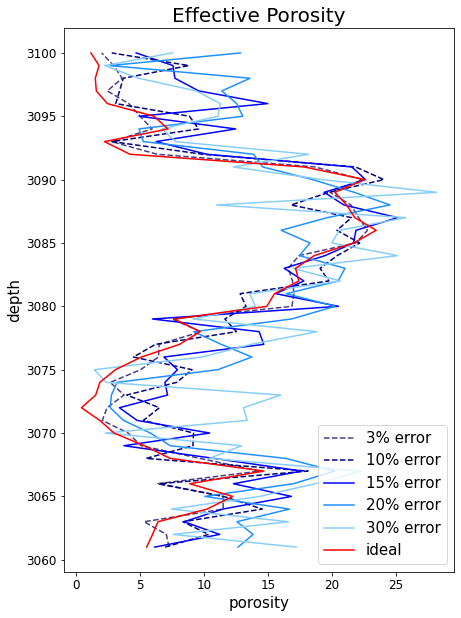

In [127]:
draw_porosity_for_spoiled_wells(depth, all_por, all_por_3, all_por_10, all_por_15, all_por_20, all_por_30)

## Сглаживание кривых 

In [144]:
from scipy.signal import savgol_filter

# Savitzky-Golay filter
def filter_porosity(por, window = 13):
    por_filtered = savgol_filter(por, window, 3)
    return por_filtered

In [169]:
spline_0 = filter_porosity(all_por)
spline_3 = filter_porosity(all_por_3)
spline_10 = filter_porosity(all_por_10)
spline_15 = filter_porosity(all_por_15, window = 17)
spline_20 = filter_porosity(all_por_20, window = 17)
spline_30 = filter_porosity(all_por_30, window = 21)

In [170]:
def draw_filtered_porosity(depth, spline_0, spline_3, spline_10, spline_15, spline_20, spline_30):

    plt.figure(figsize = (7, 10))
    plt.xlabel('porosity', fontsize = 15)
    plt.ylabel('depth', fontsize = 15)
    plt.title('Filtered Effective Porosity', fontsize = 20)
    
    plt.plot(spline_3, depth, c = '#483D8B', linestyle = '--')
    plt.plot(spline_10, depth, c = '#000080', linestyle = '--')
    plt.plot(spline_15, depth, c = '#0000FF')
    plt.plot(spline_20, depth, c = '#1E90FF')
    plt.plot(spline_30, depth, c = '#87CEFA')
    plt.plot(all_por, depth, c = 'k')
    plt.plot(spline_0, depth, c = 'r')
    
    plt.legend(['3% error', '10% error', '15% error', '20% error', '30% error', 'ideal', 'ideal \nfiltered'], fontsize = 15)

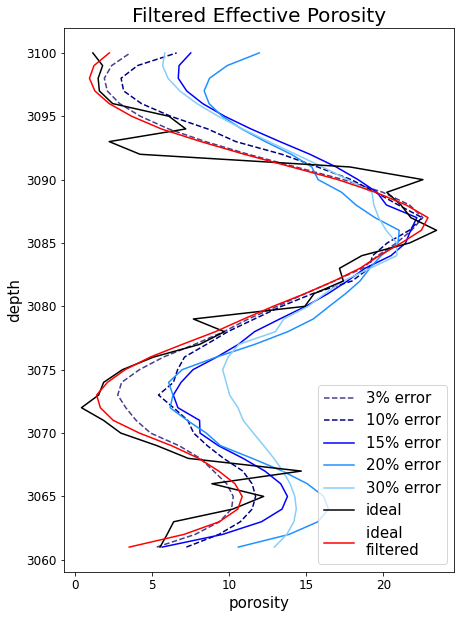

In [171]:
draw_filtered_porosity(depth, spline_0, spline_3, spline_10, spline_15, spline_20, spline_30)